## Potential Vorticity Fluxes 

The PV equation in Z-coordinates also has the form of a passive tracer equation. Here we look at its eddy fluxes. 

$$
\overline{u'q'} = (\overline{u'v'})_x + 0.5*(\overline{v'^2 - u'^2 + \frac{b'^2}{N^2}})_y + (\frac{f_o}{N^2} \overline{u'b'})_z
$$
$$
\overline{v'q'} = -(\overline{u'v'})_y + 0.5*(\overline{v'^2 - u'^2 - \frac{b'^2}{N^2}})_x + (\frac{f_o}{N^2} \overline{v'b'})_z
$$

In [1]:
# load modules 
import xarray as xr
from matplotlib import pyplot as plt
from xgcm import Grid, generate_grid_ds
import numpy as np
%matplotlib inline

In [2]:
Model_Tav = xr.open_dataset('./analysis_data_files/ZA_model_Tav.nc')

In [3]:
grid = Grid(Model_Tav)

In [4]:
dx = 5e3
dy = 5e3

g=9.81
alpha=2e-4
f0= -1.1e-4 
beta = 1.4e-11

In [7]:
# no spatial averaging
upvp = grid.interp(grid.interp(Model_Tav.UVtave , 'X'), 'Y', boundary='extend') \
                   - grid.interp(Model_Tav.uVeltave,'X')*grid.interp(
                       Model_Tav.vVeltave, 'Y', boundary='extend')
vpvp = grid.interp(Model_Tav.VVtave, 'Y', boundary='extend')  - grid.interp(
                        Model_Tav.vVeltave, 'Y', boundary='extend')**2
upup = grid.interp(Model_Tav.UUtave, 'X') - grid.interp(Model_Tav.uVeltave, 'X')**2

upbp = g*alpha*(grid.interp(Model_Tav.UTtave,'X') - grid.interp(Model_Tav.uVeltave, 'X'
                                                      )*Model_Tav.Ttave)
vpbp = g*alpha*(grid.interp(Model_Tav.VTtave,'Y', boundary='extend') - grid.interp(
        Model_Tav.vVeltave, 'Y', boundary='extend')*Model_Tav.Ttave)

bpbp = (g*alpha)*(g*alpha)*(Model_Tav.TTtave - Model_Tav.Ttave**2)

N2 = g*alpha*grid.interp(grid.diff(Model_Tav.Ttave, 'Z', boundary='extend')/
                 grid.diff(Model_Tav.Z, 'Z',boundary='extend'), 
                 'Z', boundary='extend')

In [8]:
# PV fluxes 

## u'q' 
# vorticity terms 
upqp1 =  grid.interp(grid.diff(upvp, 'X')/dx ,'X')

upqp2 = 0.5*grid.interp( grid.diff(vpvp -upup + bpbp/N2, 'Y', boundary='extend')/dy, 
                    'Y', boundary='extend')

# b flux term
upqp3 = f0*grid.interp( grid.diff(upbp/N2 ,'Z', boundary='extend')/
                       grid.diff(Model_Tav.Z, 'Z', boundary='extend'),
                      'Z', boundary='extend')
upqp = upqp1 + upqp2 + upqp3 

# vpqp
# vorticity terms
vpqp1 = 0.5*grid.interp( grid.diff(vpvp -upup - bpbp/N2, 'X')/dx,'X')

vpqp2 = -grid.interp(grid.diff(upvp, 'Y', boundary='extend')/dy ,
                      'Y', boundary='extend')
# b flux term
vpqp3 = f0*grid.interp(grid.diff(vpbp/N2 ,'Z', boundary='extend')/
                       grid.diff(Model_Tav.Z, 'Z', boundary='extend'),
                      'Z', boundary='extend')
vpqp = vpqp1 + vpqp2 + vpqp3 

/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/xgcm/grid.py:1838: RuntimeWarning: invalid value encountered in add
  return 0.5 * (data_left + data_right)
/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/xgcm/grid.py:1838: RuntimeWarning: invalid value encountered in add
  return 0.5 * (data_left + data_right)


In [9]:
PV_fluxes = xr.Dataset()

PV_fluxes['upqpx'] = upqp1
PV_fluxes['upqpy'] = upqp2
PV_fluxes['upqpz'] = upqp3
PV_fluxes['upqp'] = upqp

PV_fluxes['vpqpx'] = vpqp1
PV_fluxes['vpqpy'] = vpqp2
PV_fluxes['vpqpz'] = vpqp3
PV_fluxes['vpqp'] = vpqp

In [16]:
PV_fluxes_coarse = PV_fluxes.coarsen(XC=10, YC=10).mean()

/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


### PV gradient 
$$
\nabla \overline{Q} = \beta\hat{j} - f \frac{\partial \mathbf{S}}{\partial z} ,
$$
where $\mathbf{S}= - \nabla B/ B_Z$. 

In [32]:
Sx = - g*alpha*grid.interp(grid.diff(Model_Tav.Ttave, 'X')/dx,'X')/N2
Sy = - g*alpha*grid.interp(grid.diff(Model_Tav.Ttave, 'Y', boundary='extend')/dy,
                           'Y', boundary='extend')/N2

f = f0 + Model_Tav.YC*beta

Q_x = -f*grid.interp(grid.diff(Sx, 'Z', boundary='extend')/
                    grid.diff(Model_Tav.Z, 'Z',boundary='extend'),
                    'Z', boundary='extend')
Q_y = beta -f*grid.interp(grid.diff(Sy, 'Z', boundary='extend')/
                    grid.diff(Model_Tav.Z, 'Z',boundary='extend'),
                    'Z', boundary='extend')


/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/xgcm/grid.py:1838: RuntimeWarning: invalid value encountered in add
  return 0.5 * (data_left + data_right)
/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/xgcm/grid.py:1842: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left


In [35]:
PV_grads = xr.Dataset()
PV_grads['dQdx'] = Q_x
PV_grads['dQdy'] = Q_y

In [36]:
PV_grads_coarse = PV_grads.coarsen(XC=10, YC=10).mean()

In [39]:
diff_tensor = xr.open_dataset('analysis_data_files/diff_tensor_ZA_50km.nc')

In [41]:
rec_PV_fluxes_coarse= xr.Dataset()

In [53]:
rec_PV_fluxes_coarse['upqp'] = - (diff_tensor.Kcorr.sel(i=0, j=0)*PV_grads_coarse['dQdx'] + 
                            diff_tensor.Kcorr.sel(i=0, j=1)*PV_grads_coarse['dQdy'])
rec_PV_fluxes_coarse['vpqp'] = - (diff_tensor.Kcorr.sel(i=1, j=0)*PV_grads_coarse['dQdx'] + 
                            diff_tensor.Kcorr.sel(i=1, j=1)*PV_grads_coarse['dQdy'])

rec_PV_fluxes_coarse['upqpS'] = - (diff_tensor.STcorr.sel(i=0, j=0)*PV_grads_coarse['dQdx'] + 
                            diff_tensor.STcorr.sel(i=0, j=1)*PV_grads_coarse['dQdy'])
rec_PV_fluxes_coarse['vpqpS'] = - (diff_tensor.STcorr.sel(i=1, j=0)*PV_grads_coarse['dQdx'] + 
                            diff_tensor.STcorr.sel(i=1, j=1)*PV_grads_coarse['dQdy'])

rec_PV_fluxes_coarse['upqpA'] = - (diff_tensor.ATcorr.sel(i=0, j=0)*PV_grads_coarse['dQdx'] + 
                            diff_tensor.ATcorr.sel(i=0, j=1)*PV_grads_coarse['dQdy'])
rec_PV_fluxes_coarse['vpqpA'] = - (diff_tensor.Kcorr.sel(i=1, j=0)*PV_grads_coarse['dQdx'] + 
                            diff_tensor.ATcorr.sel(i=1, j=1)*PV_grads_coarse['dQdy'])

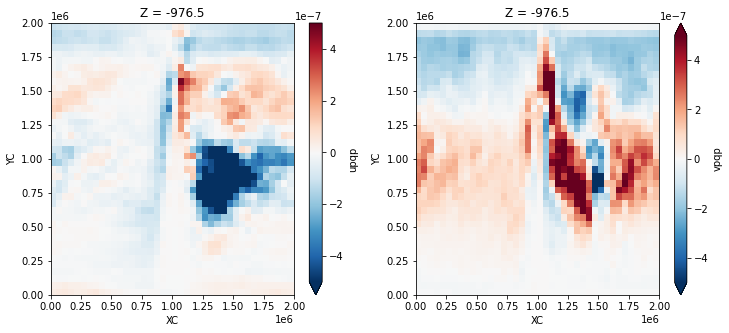

In [54]:
plt.figure(figsize=(12,5))

plt.subplot(121)
PV_fluxes_coarse['upqp'].sel(Z=-1000, method='nearest').plot(vmin=-5e-7)

plt.subplot(122)
PV_fluxes_coarse['vpqp'].sel(Z=-1000, method='nearest').plot(vmin=-5e-7)

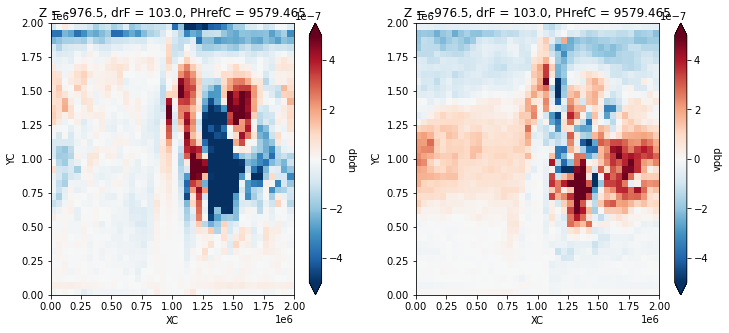

In [55]:
plt.figure(figsize=(12,5))

plt.subplot(121)
rec_PV_fluxes_coarse['upqp'].sel(Z=-1000, method='nearest').plot(vmin=-5e-7)

plt.subplot(122)
rec_PV_fluxes_coarse['vpqp'].sel(Z=-1000, method='nearest').plot(vmin=-5e-7)

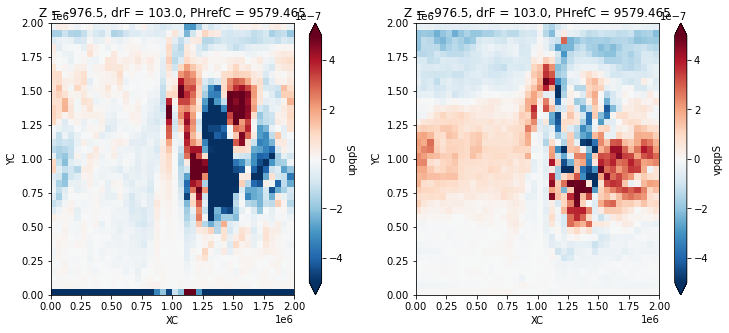

In [56]:
plt.figure(figsize=(12,5))

plt.subplot(121)
rec_PV_fluxes_coarse['upqpS'].sel(Z=-1000, method='nearest').plot(vmin=-5e-7)

plt.subplot(122)
rec_PV_fluxes_coarse['vpqpS'].sel(Z=-1000, method='nearest').plot(vmin=-5e-7)

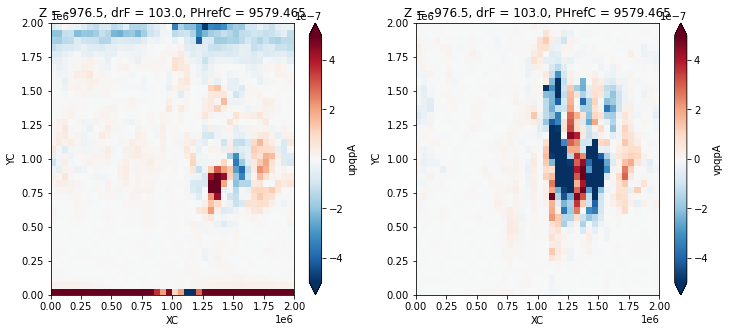

In [52]:
plt.figure(figsize=(12,5))

plt.subplot(121)
rec_PV_fluxes_coarse['upqpA'].sel(Z=-1000, method='nearest').plot(vmin=-5e-7)

plt.subplot(122)
rec_PV_fluxes_coarse['vpqpA'].sel(Z=-1000, method='nearest').plot(vmin=-5e-7)

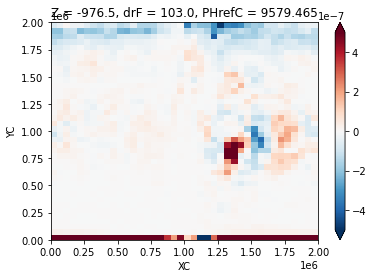

In [57]:
(rec_PV_fluxes_coarse['upqp'] - rec_PV_fluxes_coarse['upqpS']).sel(Z=-1000, method='nearest').plot(vmin=-5e-7)